In [1]:
cd ..

/home/ikboljonsobirov/uncertainty-benchmark/experiments


In [2]:
import medmnist
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from models.models_mcd import ResNet18_MCD, ResNet50_MCD

from acsconv.converters import ACSConverter, Conv2_5dConverter, Conv3dConverter
from utils.utils import Transform3D, model_to_syncbn
import os

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension


In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/organmnist3d/231228_131656_resnet18mcd/best_model.pth'
# checkpoint_path = '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/nodulemnist3d/231228_122254_resnet18mcd/best_model.pth'

data_flag = 'organmnist3d'
# data_flag = 'nodulemnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
n_channels = info['n_channels']
n_classes = len(info['label'])

# load the data
train_dataset = DataClass(split='train',  download=download)
val_dataset = DataClass(split='val',  download=download)
test_dataset = DataClass(split='test',  download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/organmnist3d.npz


In [5]:
def mc_dropout_inference(model, data_loader, num_samples):
    model.eval()  # Ensure dropout is active
    total_output = 0
    
    with torch.no_grad():
        for i in range(num_samples):
            for data, _ in data_loader:
                data = data.to(device)
                output = model(data)
                total_output += output

    return total_output / num_samples

# Perform MC Dropout inference
model = ResNet18_MCD(in_channels=n_channels, num_classes=n_classes)
model = model_to_syncbn(ACSConverter(model))

model.to(device)
model = model.double()
model.load_state_dict(torch.load(checkpoint_path)['net'])

# mc_output = mc_dropout_inference(model, test_loader, num_samples=5)

<All keys matched successfully>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import torch.nn.functional as F


In [7]:
def mc_dropout_inference(model, data_loader, num_samples):
    model.eval()  # Ensure dropout is active
    all_outputs = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            outputs = [model(data).detach().cpu().numpy() for _ in range(num_samples)]

            all_outputs.append(np.array(outputs))


    return all_outputs #np.mean(all_outputs, axis=0), np.std(all_outputs, axis=0)

# Perform MC Dropout inference
all_outputs = mc_dropout_inference(model, test_loader, num_samples=5)


In [8]:
# Concatenating along the second dimension
concatenated_output = np.concatenate(all_outputs, axis=1)
# apply softmax to the concatenated output
concatenated_output = F.softmax(torch.tensor(concatenated_output), dim=2)
# Checking the shape of the concatenated output
concatenated_output.shape


torch.Size([5, 610, 11])

In [9]:
mc_mean, mc_uncertainty = torch.mean(concatenated_output, axis=0), torch.std(concatenated_output, axis=0)

In [10]:
mc_mean[0]

tensor([4.7116e-04, 3.7696e-09, 3.0670e-08, 3.5347e-08, 3.7389e-05, 1.6573e-05,
        6.7463e-05, 2.2569e-07, 3.2152e-06, 1.2266e-04, 9.9928e-01],
       dtype=torch.float64)

In [11]:
mc_uncertainty[0]

tensor([5.2686e-04, 3.2318e-09, 3.3801e-08, 3.7660e-08, 3.0527e-05, 1.9490e-05,
        7.4196e-05, 2.3135e-07, 2.8475e-06, 1.1411e-04, 7.0995e-04],
       dtype=torch.float64)

In [12]:
targets = []
for _, target in test_loader:
    target = target.numpy()
    print(target.shape)
    targets.append(target)

(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(2, 1)


In [13]:
targets  = np.concatenate(targets, axis=0)

In [14]:
mc_mean

tensor([[4.7116e-04, 3.7696e-09, 3.0670e-08,  ..., 3.2152e-06, 1.2266e-04,
         9.9928e-01],
        [3.4071e-10, 1.3660e-05, 9.9999e-01,  ..., 2.0891e-09, 1.8663e-07,
         7.3687e-08],
        [1.2324e-07, 1.4329e-05, 9.1994e-06,  ..., 5.1134e-08, 3.3091e-06,
         2.8041e-07],
        ...,
        [1.5812e-07, 2.7331e-04, 1.8456e-04,  ..., 3.4507e-08, 2.3050e-06,
         1.6769e-07],
        [1.0302e-01, 2.2308e-01, 5.4584e-04,  ..., 6.5988e-04, 2.3289e-03,
         7.9798e-04],
        [1.4956e-03, 1.1860e-04, 1.6732e-01,  ..., 3.5185e-03, 6.8101e-01,
         7.6615e-02]], dtype=torch.float64)

In [15]:
total_f1 = f1_score(targets, np.argmax(mc_mean, axis=1), average='macro')
total_f1

0.9433848255128889

In [101]:
np.argsort(predicted_class_uncertainty).numpy()[::-1]

array([206, 170, 145, 565, 384, 298, 161, 223, 329, 472, 586, 263, 280,
       180, 398, 210, 537, 191, 283,  65, 203, 336, 137, 555,  45, 238,
       351, 122,  84,  67, 567, 355, 232, 489, 314, 143, 402,  46, 449,
       553, 359, 179,  16, 599, 578, 152, 249, 457, 390, 608, 556, 189,
       425, 362, 264,  95, 315, 540, 155, 462, 358,  43, 387, 530, 266,
       373, 456, 144,  42, 609,  32, 333, 172, 199, 392, 401, 440,  61,
        26,  15, 190, 569, 225, 174, 141, 417, 407, 338, 305, 374, 343,
       255, 539, 327, 364, 570,   8, 207, 527, 126, 544, 120, 348, 542,
       195, 467, 357, 452, 531, 365, 520,  64,  25, 319,  66,  69,  13,
        41, 197,  62,  70, 183,  60, 536, 564, 118, 162, 346,  29, 258,
       136, 479, 585, 187, 464, 603, 269,  82, 290, 219, 551, 185, 484,
       438, 198, 260, 571, 416, 500, 102, 296, 104, 503, 409, 272, 471,
       369, 378, 473, 459,  75, 131, 293, 389, 282, 252, 304,  36, 548,
        39, 239, 597, 270, 433, 233, 533, 228, 522, 164, 557, 41

0 0.001 0.9344262295081968
6 0.01108080808080808 0.9354304635761589
12 0.021161616161616163 0.9381270903010034
19 0.031242424242424245 0.9441624365482234
25 0.041323232323232324 0.9504273504273504
31 0.0514040404040404 0.9568221070811744
37 0.06148484848484849 0.9616055846422339
43 0.07156565656565657 0.9664902998236331
49 0.08164646464646465 0.9679144385026738
55 0.09172727272727273 0.9711711711711711
62 0.1018080808080808 0.9744525547445255
68 0.11188888888888888 0.977859778597786
74 0.12196969696969698 0.9813432835820896
80 0.13205050505050506 0.9830188679245283
86 0.14213131313131314 0.982824427480916
92 0.15221212121212122 0.9826254826254827
98 0.1622929292929293 0.984375
105 0.17237373737373737 0.9861386138613861
111 0.18245454545454545 0.9859719438877755
117 0.19253535353535353 0.9878296146044625
123 0.2026161616161616 0.9876796714579056
129 0.2126969696969697 0.9896049896049897
135 0.22277777777777777 0.9894736842105263
142 0.23285858585858585 0.9914529914529915
148 0.242939393

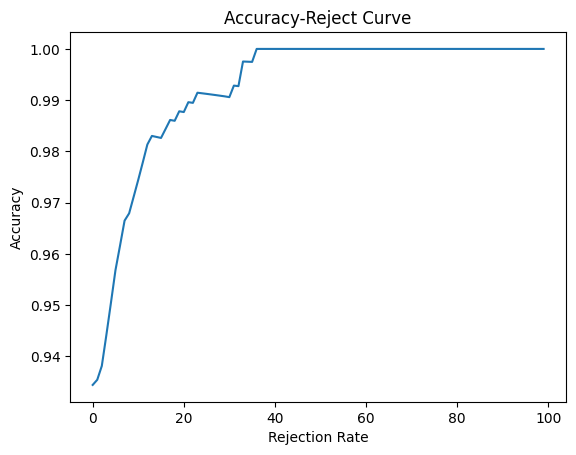

In [16]:
# Assuming predictions are the class with the highest mean probability
predicted_classes = mc_mean.argmax(axis=1)
predicted_class_uncertainty = mc_uncertainty[np.arange(len(mc_uncertainty)), predicted_classes]

# Assuming test_labels is a list or array of the true labels
test_labels = targets
accuracies = []
rejection_rates = np.linspace(0.001, 0.999, 100)

for rejection_rate in rejection_rates:
    num_reject = int(len(predicted_class_uncertainty) * rejection_rate)
    sorted_indices = np.argsort(predicted_class_uncertainty).numpy()[::-1]

    indices_to_keep = sorted_indices[num_reject:]
    
    selected_labels = test_labels[indices_to_keep]
    selected_predictions = predicted_classes.numpy()[indices_to_keep]
    
    accuracy = accuracy_score(selected_labels, selected_predictions)
    print(num_reject, rejection_rate, accuracy)

    accuracies.append(accuracy)

# Plotting the accuracy-reject curve
plt.plot(accuracies)
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve')
plt.show()


In [17]:
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000

# Initialize list to store upper and lower bounds of uncertainty
lower_bounds = []
upper_bounds = []

for rejection_rate in rejection_rates:
    num_reject = int(len(predicted_class_uncertainty) * rejection_rate)
    indices_to_keep = np.argsort(predicted_class_uncertainty).numpy()[::-1][num_reject:]
    
    bootstrap_accuracies = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        boot_indices = resample(indices_to_keep)
        boot_labels = targets[boot_indices]
        boot_predictions = predicted_classes.numpy()[boot_indices]

        # Calculate bootstrap accuracy
        boot_accuracy = accuracy_score(boot_labels, boot_predictions)
        bootstrap_accuracies.append(boot_accuracy)

    # Calculate the lower and upper bound of the uncertainty
    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)

    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)


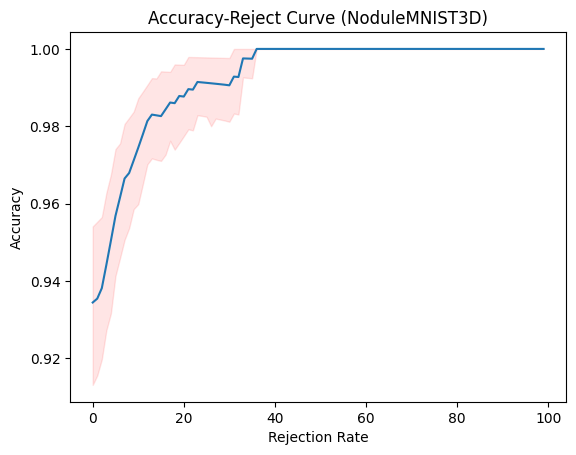

In [18]:
# draw the uncertainty interval
plt.plot(accuracies,label='Accuracy')
plt.fill_between(range(len(lower_bounds)), lower_bounds, upper_bounds, color='red', alpha=0.1, label='Uncertainty Region')
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve (OrganMNIST3D)')
plt.show()


In [105]:
# lets get the area under this curve
from sklearn.metrics import auc
auc(rejection_rates, accuracies)

0.9507286015222802